## Code for Acres of Sorghum planted by type. 2019 plantings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable # used to identify main plot axis
import geopandas as gdp #reference for Geopandas https://geopandas.org/mapping.html  
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # used to make a smaller axis for cax

In [2]:
# Load Shape Field for US County Map
fp= 'C:/code/us_county/US_County_Boundaries.shp'
map_df = gdp.read_file(fp)

In [3]:
# Data from 2019 FSA Plantings (Jan 2020 report, all types sorghum)
df= pd.read_csv('C:/code/2019_sorghum_acres/2019_fsa_acres_web_010220_sorghums.csv',
                dtype={"State County Code": str}) #convert FIPs to string for mapping purposes. tutorial from herehttps://plotly.com/python/choropleth-maps/#base-map-configuration 
cols = df.columns.str.replace(' ', '') # change the column names to element spaces
df.columns = cols # replace the column names in the dataframe 
df['PlantedAcres'] = df['PlantedAcres'].str.replace(',','').astype(float) #change so I can sum in the pivot table function 
df.head()

,StateCode,CountyCode,CropCode,State,County,StateCountyCode,Crop,CropType,IntendedUse,IrrigationPractice,PlantedAcres,VolunteerAcres,FailedAcres,PreventedAcres,NotPlantedAcres,PlantedandFailedAcres
0,1,1,51,Alabama,Autauga,01001,SORGHUM,GRAIN,Grain,N,406.16,0.0,0.0000,0.0000,0.0,406.1600
1,1,3,51,Alabama,Baldwin,01003,SORGHUM,GRAIN,Forage,N,64.31,0.0,0.0000,0.0000,0.0,64.3100
2,1,3,51,Alabama,Baldwin,01003,SORGHUM,GRAIN,Grain,N,839.06,0.0,0.0000,0.0000,0.0,839.0600
3,1,5,51,Alabama,Barbour,01005,SORGHUM,GRAIN,Grain,N,102.81,0.0,0.0000,0.0000,0.0,102.8100
4,1,5,51,Alabama,Barbour,01005,SORGHUM,GRAIN,Grazing,N,18.49,0.0,0.0000,0.0000,0.0,18.4900


In [4]:
#Convert to a table with County and Acres for each croptype
data = pd.pivot_table(df,index=['StateCountyCode'],columns='Crop',values='PlantedAcres',aggfunc=np.sum, fill_value=0)
data = data.reset_index()  # make crop reference number the index 

In [5]:
data

Crop,StateCountyCode,SORGHUM,SORGHUM DUAL PURPOSE,SORGHUM FORAGE
0,01001,406.16,0.00,0.00
1,01003,903.37,0.00,0.00
2,01005,121.30,0.00,40.00
3,01013,121.00,0.00,0.00
4,01015,19.33,0.00,0.00
...,...,...,...,...
1922,56027,0.00,0.00,1134.08
1923,56029,0.00,0.00,91.86
1924,56033,5.37,0.00,0.00
1925,56043,0.00,5.62,88.47


In [24]:
# Rename columns for calling
#data.info()
#print(data.columns)

data = data.rename(columns={'StateCountyCode': 'CTFIPS'})
data = data.rename(columns={'SORGHUM  DUAL PURPOSE': 'DUAL'})
data = data.rename(columns={'SORGHUM FORAGE': 'FORAGE'})

In [31]:
# Add zero to match base map codes
data.CTFIPS.str = data.CTFIPS.str.zfill(5)

In [32]:
# Merge geopandas base map and county data
merged = pd.merge(left=map_df, right=data, on='CTFIPS', how='left')  # left keeps all map_df data and fills with NaNs for right df missing values
#merged['diversity']=merged['diversity'].fillna(0) # this is done to map on counties without data for plantings (a couple in Florida, etc)

#Drop all columns for states that will not be mapped 
merged = merged.drop(merged[merged.STATE == 'Hawaii'].index)
merged = merged.drop(merged[merged.STATE == 'Puerto Rico'].index)
merged = merged.drop(merged[merged.STATE == 'Alaska'].index)

In [33]:
# Plotting points for acres of Sorghum derived from the geometry in merged 
merged["x"] = merged.centroid.x
merged["y"] = merged.centroid.y

In [34]:
#merged['SORGHUM']=merged['SORGHUM'].fillna(0)

#merged['SORGHUM DUAL PURPOSE']=merged['SORGHUM DUAL PURPOSE'].fillna(0)
#merged['SORGHUM FORAGE']=merged['SORGHUM FORAGE'].fillna(0)

In [35]:
merged

,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,geometry,SORGHUM,DUAL,FORAGE,x,y
23,32,32015,Nevada,Lander,05,6.363202,1.506312,"POLYGON ((-116.58679 41.00040, -116.58660 40.9...",0.00,0.0,135.50,-117.037908,39.933808
24,32,32011,Nevada,Eureka,05,5.230787,1.141566,"POLYGON ((-116.58679 41.00040, -116.58361 41.0...",0.00,NaN,NaN,-116.268560,39.983892
25,06,06103,California,Tehama,05,5.126382,0.810635,"POLYGON ((-123.06547 40.28689, -123.06399 40.2...",14.88,0.0,0.00,-122.233888,40.125739
26,06,06063,California,Plumas,05,5.268348,0.713937,"POLYGON ((-121.00947 39.63960, -121.01380 39.6...",0.00,NaN,NaN,-120.838594,40.004679
27,06,06007,California,Butte,05,4.205294,0.455937,"POLYGON ((-121.89004 39.38389, -121.89022 39.3...",0.00,NaN,NaN,-121.600646,39.666921
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214,36,36081,New York,Queens,05,2.389774,0.030273,"MULTIPOLYGON (((-73.86254 40.65675, -73.86274 ...",0.00,NaN,NaN,-73.817682,40.706664
3215,42,42075,Pennsylvania,Lebanon,05,1.355480,0.099576,"POLYGON ((-76.15148 40.31570, -76.16010 40.312...",130.40,0.0,54.22,-76.457697,40.367204
3216,39,39091,Ohio,Logan,05,1.530434,0.128226,"POLYGON ((-83.55138 40.22936, -83.55213 40.229...",33.78,0.0,166.07,-83.765795,40.388464
3217,39,39149,Ohio,Shelby,05,1.451640,0.112817,"POLYGON ((-84.43269 40.19714, -84.43272 40.206...",0.00,0.0,158.21,-84.204762,40.331558


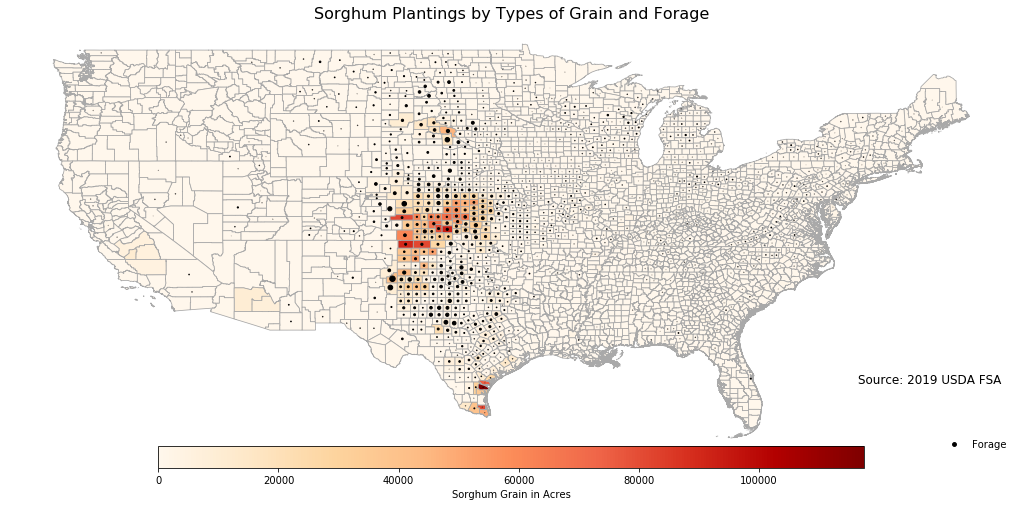

In [69]:
# reference https://geopandas.readthedocs.io/en/latest/mapping.html#creating-a-legend 
# This code has method to append to an axis that is the ratio of the main axis. This is used for colorbar display
fig, ax = plt.subplots(1, figsize=(14, 20))#constrained_layout=True
divider = make_axes_locatable(ax)

cax = inset_axes(ax,
                    width="70%",  # width = 50% of parent_bbox width
                    height="5%",  # height : 5%
                    loc='lower center',
                    borderpad=-1)

#cax = divider.append_axes("bottom", size="5%", pad=.3, aspect = 10) 

cmap = 'OrRd'

colorscale = ["#171c42","#223f78","#1267b2","#4590c4","#8cb5c9","#b6bed5","#dab2be",
              "#d79d8b","#c46852","#a63329","#701b20","#3c0911"]

plot = merged.plot(column=merged.SORGHUM, 
            cmap= cmap, 
            ax=ax, 
            linewidth=0.8,
            edgecolor='darkgray',
            legend = True,
            legend_kwds={'label': "Sorghum Grain in Acres",'panchor':'0.5, 1.0', 'fraction':'.1', 
                           'orientation': "horizontal", 'aspect':'5'}, 
            cax=cax, 
            ) 

# Sorghum Acres by County Scatter Plot
x, y = merged['x'].values, merged['y'].values
x2 = merged['x'].values + .9
scatter = ax.scatter(x, y, marker="o", c ='black', zorder=5, s=merged.FORAGE*.001, alpha = 1, label="Forage")
#scatter = ax.scatter(x, y, marker="o", c ='black', zorder=5, s=merged.DUAL*.001, alpha = 1, label="Dual Purpose")

ax.legend (loc="lower right", frameon=False)
#ax.legend = True

#'shrink':'.5', 'fraction':'.046','aspect':'20'
ax.set_title('Sorghum Plantings by Types of Grain and Forage', size = 16, loc='center')
ax.text(x= -74 , y= 28 , s= 'Source: 2019 USDA FSA', size=12) 
ax.set_axis_off()
ax.axis = ('equal')
frameon=False 
plt.axis("tight")
plt.subplots_adjust(left=0, right=1, bottom=0, top=1) # this is not compatiple with contrained layout
plt.savefig('Sorghum_Plantings_forage_2019', bbox_inches='tight', dpi=200, pad_inches = 0)
plt.show()